In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

class PINN2(nn.Module):
    def __init__(self, layers):
        super(PINN2, self).__init__()
        self.layers = layers
        self.net = nn.Sequential()
        for i in range(len(layers) - 2):
            self.net.add_module(f'layer_{i}', nn.Linear(layers[i], layers[i+1]))
            self.net.add_module(f'activation_{i}', nn.Tanh())
        self.net.add_module('output', nn.Linear(layers[-2], layers[-1]))

    def forward(self, x, y, t):
        X_neu = torch.cat([x, y, t], dim=1)
        u = self.net(X_neu)
        return u

    def net_u(self, x, y, t):
        u = self.forward(x, y, t)

        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)[0]

        return u, u_t, u_x, u_y

    def loss_complete(self, X, indx_inner, indx_init, indx_bound, loss_pde, loss_boundary, loss_initial, weight_inner, weight_boundary, b_points, ic_points, in_points):

        t = X[:,0].reshape(-1, 1)
        x = X[:,1].reshape(-1, 1)
        y = X[:,2].reshape(-1, 1)

        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)

        u, u_t, u_x, u_y = self.net_u(x, y, t)

        loss_inter = loss_pde(u[indx_inner], u_t[indx_inner], u_x[indx_inner], u_y[indx_inner])

        loss_init = loss_initial(u[indx_init], x[indx_init], y[indx_init], t[indx_init])

        loss_bound = loss_boundary(u[indx_bound], x[indx_bound], y[indx_bound], t[indx_bound])

        loss_sum = weight_inner * (1 / in_points * torch.mean(loss_inter**2)) + weight_boundary * ((1 / (ic_points**2) * torch.mean(loss_init**2)) + (1 / (4 * (b_points**2)) * torch.mean(loss_bound**2)))

        return loss_sum

    def train(self, x_left, x_right, y_left, y_right, T, boundary_points, inital_data_points, inner_points, training_time, loss_pde, loss_boundary, loss_initial, weight_inner, weight_boundary, lrate):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)

        X_1, Y_1, T_1 = torch.meshgrid(torch.linspace(x_right, x_left, boundary_points), torch.linspace(y_right, y_right, 1), torch.linspace(0, T, boundary_points), indexing='xy')
        X_bound_1 = torch.hstack((T_1.flatten()[:, None], X_1.flatten()[:, None], Y_1.flatten()[:, None])).to(device)

        X_1, Y_1, T_1 = torch.meshgrid(torch.linspace(x_right, x_left, boundary_points), torch.linspace(y_left, y_left, 1), torch.linspace(0, T, boundary_points), indexing='xy')
        X_bound_2 = torch.hstack((T_1.flatten()[:, None], X_1.flatten()[:, None], Y_1.flatten()[:, None])).to(device)

        X_1, Y_1, T_1 = torch.meshgrid(torch.linspace(x_left, x_left, 1), torch.linspace(y_right, y_left, boundary_points), torch.linspace(0, T, boundary_points), indexing='xy')
        X_bound_3 = torch.hstack((T_1.flatten()[:, None], X_1.flatten()[:, None], Y_1.flatten()[:, None])).to(device)

        X_1, Y_1, T_1 = torch.meshgrid(torch.linspace(x_left, x_left, 1), torch.linspace(y_right, y_left, boundary_points), torch.linspace(0, T, boundary_points), indexing='xy')
        X_bound_4 = torch.hstack((T_1.flatten()[:, None], X_1.flatten()[:, None], Y_1.flatten()[:, None])).to(device)

        X_bound = torch.cat([X_bound_1, X_bound_2, X_bound_3, X_bound_4], dim=0)

        X_1, Y_1, T_1 = torch.meshgrid(torch.linspace(x_left, x_right, inital_data_points), torch.linspace(y_left, y_right, inital_data_points), torch.linspace(0, 0, 1), indexing='xy')
        X_init = torch.hstack((T_1.flatten()[:, None], X_1.flatten()[:, None], Y_1.flatten()[:, None])).to(device)

        X_b_i = torch.cat([X_bound, X_init], dim=0)

        indx_bound = torch.arange(0, 4 * (boundary_points**2), step=1).to(device)
        indx_init = torch.arange(4 * (boundary_points**2), (inital_data_points**2) + 4 * (boundary_points**2), step=1).to(device)
        indx_inner = torch.arange((inital_data_points**2) + 4 * (boundary_points**2), inner_points + (inital_data_points**2) + 4 * (boundary_points**2), step=1).to(device)

        final_losses = []

        optimizer = torch.optim.Adam(self.parameters(), lr=lrate)

        for it in range(training_time):
            x = torch.FloatTensor(inner_points).uniform_(x_left, x_right).reshape(-1, 1).to(device)
            y = torch.FloatTensor(inner_points).uniform_(y_left, y_right).reshape(-1, 1).to(device)
            t = torch.FloatTensor(inner_points).uniform_(0, T).reshape(-1, 1).to(device)
            X_inner = torch.cat([t, x, y], dim=1).to(device)
            X_full = torch.cat([X_b_i, X_inner], dim=0).to(device)

            optimizer.zero_grad()
            loss = self.loss_complete(X_full, indx_inner, indx_init, indx_bound, loss_pde, loss_boundary, loss_initial, weight_inner, weight_boundary, boundary_points, inital_data_points, inner_points)
            final_losses.append(loss.item())

            if it % 50 == 1:
                print(f"Training number: {it}, Loss: {loss.item()}")

            loss.backward()
            optimizer.step()

        with torch.no_grad():
            plt.plot(range(training_time), final_losses)
            plt.ylabel('Loss')
            plt.xlabel('Training Iterations')
            plt.title('Training Loss')
            plt.show()

    def plot_solution3D(self, x_left, x_right, y_left, y_right, points_x, time):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        X_1, Y_1, T_1 = torch.meshgrid(torch.linspace(-2, 2, 20), torch.linspace(-2, 2, 20), torch.linspace(time, time, 1), indexing='xy')
        X = torch.hstack((X_1.flatten()[:, None], Y_1.flatten()[:, None], T_1.flatten()[:, None])).to(device)

        x = X[:,0].reshape(-1, 1)
        y = X[:,1].reshape(-1, 1)
        t = X[:,2].reshape(-1, 1)

        x.requires_grad_(True)
        y.requires_grad_(True)
        t.requires_grad_(True)

        X_neu = torch.cat([x, y, t], dim=1).to(device)
        u, u_t, u_x, u_y = self.net_u(x, y, t)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x_plot = X_1.detach().cpu().numpy().reshape(points_x, points_x)
        y_plot = Y_1.detach().cpu().numpy().reshape(points_x, points_x)
        u_plot = u.detach().cpu().numpy().reshape(x_plot.shape)
        ax.plot_surface(x_plot, y_plot, u_plot.reshape(x_plot.shape))
        ax.view_init(elev=30, azim=50)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("u")
        plt.title("Approximate Solution")
        plt.show()
        plt.close()


In [ ]:
def loss_advection2D(u, u_t, u_x, u_y):
  return u_t + 0.5*u_x + 0.5*u_y

def loss_initial(u,x,y,t):
  return u - torch.exp((torch.pow(x,2)+torch.pow(y,2))*(-5))

def loss_boundary(u,x,y,t):
  return u


In [ ]:
neunet = PINN2([3, 20, 20, 20, 1])

neunet.train(-2, 2, -2, 2, 1, 50, 50, 500, 400, loss_advection2D, loss_boundary, loss_initial, 1, 1, 0.01)

Training number: 1, Loss: 1.0527970516704954e-05
Training number: 51, Loss: 4.796185294253519e-06
Training number: 101, Loss: 1.3433253798211808e-06
Training number: 151, Loss: 2.197575241780214e-07
Training number: 201, Loss: 5.320698903688026e-08


KeyboardInterrupt: 

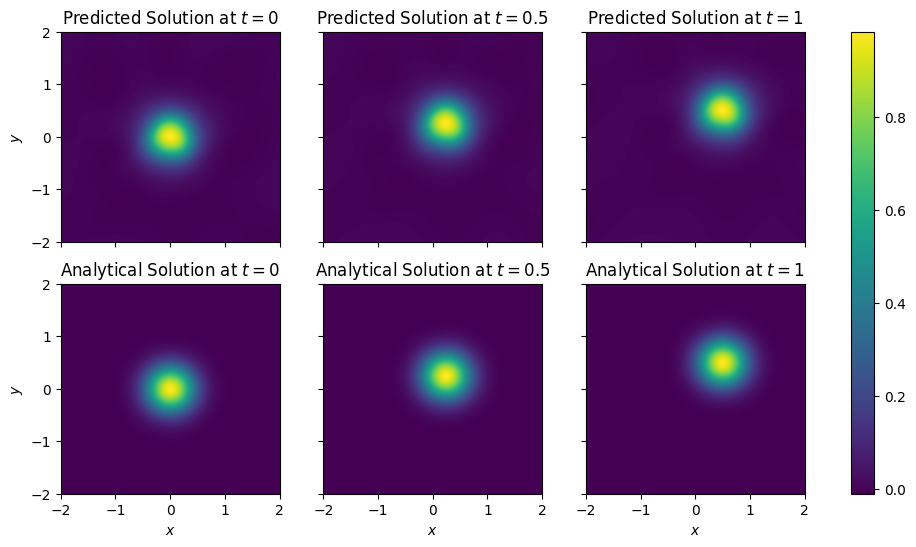

In [ ]:
X_1, Y_1, T_1 = torch.meshgrid(torch.linspace(-2, 2, 500), torch.linspace(-2, 2, 500), torch.linspace(1, 1, 1), indexing='xy')
X = torch.hstack((X_1.flatten()[:, None], Y_1.flatten()[:, None], T_1.flatten()[:, None]))
x = X[:, 0].reshape(-1, 1)
y = X[:, 1].reshape(-1, 1)
t = X[:, 2].reshape(-1, 1)
x.requires_grad_(True)
y.requires_grad_(True)
t.requires_grad_(True)

fig, axs = plt.subplots(2, 3, sharey=True)
fig.set_size_inches(12, 6)

# Plot for t = 0
t_1 = t * 0
u, u_t, u_x, u_y = neunet.net_u(x, y, t_1)
x_plot = X_1.detach().numpy().reshape(500, 500)
y_plot = Y_1.detach().numpy().reshape(500, 500)
u_plot = u.detach().numpy().reshape(x_plot.shape)
pcm = axs[0, 0].imshow(u_plot, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
axs[0, 0].set_title('Predicted Solution at $t = 0$')

u_ex = np.exp(-5 * ((x_plot)**2 + (y_plot)**2))
axs[1, 0].imshow(u_ex, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
axs[1, 0].set_title('Analytical Solution at $t = 0$')

# Plot for t = 0.5
t_1 = t * 0.5
u, u_t, u_x, u_y = neunet.net_u(x, y, t_1)
u_plot = u.detach().numpy().reshape(x_plot.shape)
axs[0, 1].imshow(u_plot, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
axs[0, 1].set_title('Predicted Solution at $t = 0.5$')

u_ex = np.exp(-5 * ((x_plot - 0.25)**2 + (y_plot - 0.25)**2))
axs[1, 1].imshow(u_ex, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
axs[1, 1].set_title('Analytical Solution at $t = 0.5$')

# Plot for t = 1
t_1 = t * 1
u, u_t, u_x, u_y = neunet.net_u(x, y, t_1)
u_plot = u.detach().numpy().reshape(x_plot.shape)
axs[0, 2].imshow(u_plot, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
axs[0, 2].set_title('Predicted Solution at $t = 1$')

u_ex = np.exp(-5 * ((x_plot - 0.5)**2 + (y_plot - 0.5)**2))
axs[1, 2].imshow(u_ex, extent=[-2, 2, -2, 2], origin='lower', aspect='auto')
axs[1, 2].set_title('Analytical Solution at $t = 1$')


for ax in axs.flat:
    ax.set(xlabel='$x$', ylabel='$y$')

fig.colorbar(pcm, ax=axs[:, :], location='right', shrink=1)

for ax in axs.flat:
    ax.label_outer()

plt.savefig('Ad2_1.png')